## <font color="orange">*1. Librerias*</font>

In [ ]:
#!pip install ydata-profiling

In [ ]:
#!pip install deep_translator

In [ ]:
#!pip install pandasql

In [ ]:
#!pip install category-encoders

In [ ]:
import os
import os.path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from deep_translator import GoogleTranslator
from pandasql import sqldf

from gensim.models import Word2Vec
import category_encoders as ce

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Alojamiento del archivo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color="orange">*2. Importar los dataset desde Kaggle.com*</font>
[LINK Datasets](https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data)

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/Kaggle"

In [ ]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

 79% 12.0M/15.1M [00:01<00:00, 12.9MB/s]
100% 15.1M/15.1M [00:01<00:00, 12.5MB/s]


In [ ]:
# Descompresion de la carpeta .zip
!unzip competitive-data-science-predict-future-sales.zip

Archive:  competitive-data-science-predict-future-sales.zip
  inflating: item_categories.csv     
  inflating: items.csv               
  inflating: sales_train.csv         
  inflating: sample_submission.csv   
  inflating: shops.csv               
  inflating: test.csv                


## <font color="orange">*3. Preprocesamiento*</font>

### Objetivo:
 - Realizar el respectivo análisis exploratorio (EDA) de los datasets.
 - Realizar las transformaciones necesarias.

### Resultado:
 - Dataset **"train_cleaned"** y **"test_pred"** cuyas columnas son:
  - **item_id_scal** y **shop_id_scal**: item_id y shop_id escalados mediante MinMaxScaler.
  - **label_mean_encoder**: recategorización de item_category codificadas mediante Target/MeanEncoding.
  - **label_embedding**: recategorización de item_category codificadas mediante Embedding.
  - **columnas de mes**: del **0 al 33** en el dataset "train_cleaned" y del **-1 al 32** en el dataset "test_pred".

Datasets.

In [ ]:
item_category = pd.read_csv('/content/item_categories.csv')
items  = pd.read_csv('/content/items.csv')
shops = pd.read_csv('/content/shops.csv')
train = pd.read_csv('/content/sales_train.csv')
test = pd.read_csv('/content/test.csv')

Función utilizada en el EDA de los datasets.

In [ ]:
# Validación de datos positivos y enteros, ej. los ids
def invalids_val (values):
  '''
  Validación de valores que deben ser positivos y enteros.

  Args:
      values (np.array): Un arreglo de valores a validar.
  Returns:
      Si todos los valores son válidos, retorna un msj de OK,
      de lo contrario ...
      invalids_values (lista): Lista de valores inválidos.

  '''
  invalids_values =  [value for value in values if (value < 0) or not isinstance(value, int)]

  if not invalids_values:
    print('OK, valores positivos y enteros')

  else:
    return invalids_values

### 3.1. EDA - "*item_category*"


In [ ]:
item_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [ ]:
item_category.item_category_id.nunique()

84

In [ ]:
max_item_category_id= item_category.item_category_id.max()
max_item_category_id

83

### 3.2. EDA - "*items*"

In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [ ]:
items.item_id.nunique()

22170

In [ ]:
max_item_id= items.item_id.max()
max_item_id

22169

In [ ]:
items.item_category_id.max()

83

In [ ]:
# Validación de ids, positivos y enteros
invalids_val(items.item_category_id.unique())
invalids_val(items.item_id.unique())

OK, valores positivos y enteros
OK, valores positivos y enteros


### 3.3. EDA - "*shops*"

In [ ]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [ ]:
shops.shop_id.nunique()

60

In [ ]:
max_shop_id= shops.shop_id.max()
max_shop_id

59

In [ ]:
# Validación de ids, positivos y enteros
invalids_val(shops.shop_id.unique())

OK, valores positivos y enteros


### 3.4. EDA - "*train*"

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [ ]:
# EDA Report
report = ProfileReport(train, title="train_EDA")
report

In [ ]:
# Eliminar los duplicados
before = train.shape[0]

train.drop_duplicates(inplace = True)
train.reset_index(drop=True, inplace=True)

after = train.shape[0]

print(f'Eliminación de registros duplicados \nCantidad de registros eliminados: {before-after}')

Eliminacion de registros duplicados 
Cantidad de registros eliminanados: 6


'item_cnt_day' hace referencia a los número de productos vendidos.

'item_price' hace referencia al precio del artículo.

A continuación, se puede ver que existen valores negativos en ambas columnas, estos valores seran eliminados.

In [ ]:
# item_cnt_day negativos
train[train['item_cnt_day'] < 0].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0


In [ ]:
# Eliminar registros donde 'item_price' o 'item_cnt_day' son negativos
price_drop = list(train[train['item_price'] < 0].index)
item_cnt_drop = list(train[train['item_cnt_day'] < 0].index)

list_drop = list(set(price_drop + item_cnt_drop))
print("Eliminación de registros con 'precios' o 'cantidades vendidas' negativas")
print(f'Cantidad de registros a eliminar: {len(list_drop)}')
print(f'Porcentaje de registros a eliminar: {round(len(list_drop) * 100 / train.shape[0] , 2)}%')

train.drop(list_drop, inplace = True)

Eliminacion de registros con 'precios' o 'cantidades vendidas' negativas
 Cantidad de registros a eliminar: 7357
 Porcentaje de registros a eliminar: 0.25%


In [ ]:
# Eliminar el outlier 'item_price = 307980'
outlier_drop = list(train[train['item_price'] > 300000].index)
train.drop(outlier_drop, inplace = True)

In [ ]:
# Validación de valores positivos y enteros
invalids_val(train.shop_id.unique())
invalids_val(train.item_id.unique())
invalids_val(train.date_block_num.unique())

OK, valores positivos y enteros
OK, valores positivos y enteros
OK, valores positivos y enteros


In [ ]:
# Validación shop_id, valor max 59
train.shop_id.max()

59

In [ ]:
# Validación item_id, valor max 22169
train.item_id.max()

22169

In [ ]:
# Columna 'date' a datatime
train['date'] = pd.to_datetime(train['date'], format="%d.%m.%Y")

### 3.5. EDA - "*test*"

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [ ]:
test.ID.nunique()

214200

In [ ]:
# Validación de valores positivos y enteros
invalids_val(test.ID.unique())
invalids_val(test.shop_id.unique())
invalids_val(test.item_id.unique())

OK, valores positivos y enteros
OK, valores positivos y enteros
OK, valores positivos y enteros


In [ ]:
# Validación shop_id, valor max 59
test.shop_id.max()

59

In [ ]:
# Validación item_id, valor max 22169
train.item_id.max()

22169

### 3.6. Ventas por mes

In [ ]:
sales = {
    'date' : train['date'].dt.to_period('M').dt.to_timestamp() ,
    'item_cnt_month' : train['item_cnt_day']
         }

sales = pd.DataFrame(sales)
sales = sales.groupby(['date']).agg({'item_cnt_month':'sum'})

In [ ]:
sns.set_style("whitegrid")

Text(0, 0.5, 'item_cnt_month')

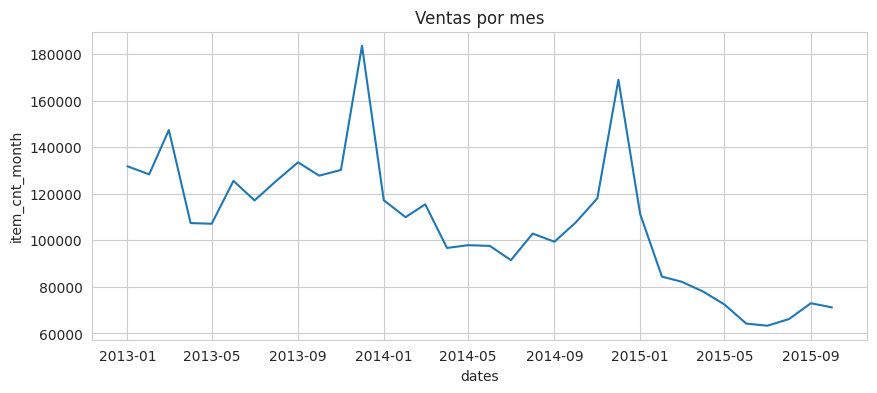

In [ ]:
# Gráfica de ventas
plt.figure(figsize = (10,4))
sns.lineplot(sales, legend = False)
plt.title('Ventas por mes')
plt.xlabel('dates')
plt.ylabel('item_cnt_month')


Text(0.5, 0, 'item_cnt_month')

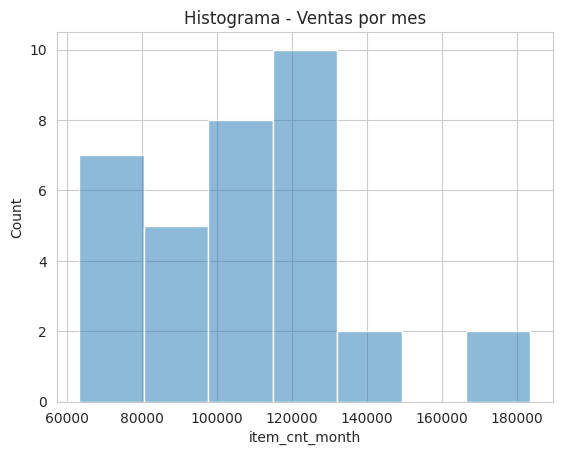

In [ ]:
# Histograma
sns.histplot(data= sales, legend = False)
plt.title('Histograma - Ventas por mes')
plt.xlabel('item_cnt_month')

### 3.7. Recategorización de los artículos

Con el fin de utilizar la categoria de los artículos como una variable para los modelos de predicción, a continuación se realiza el proceso de *recategorización* que consiste en traducir los nombres de las categorias de ruso a ingles y reagruparlas.

La columna '*label* ' contedra los resultados.

In [ ]:
def english_traductor():
  '''
  Traductor de Ruso a Ingles.
  Utilizado para las categorias

  Return:
      item_category + la columna ...
      item_category['name_en'] : columna con las traducciones.
  '''
  # Nombres de las categorias en ruso
  names_ru = list(item_category.item_category_name)

  # Traductor de ruso a ingles
  traductor = GoogleTranslator(source='ru', target='en')

  # Nombre de las categorias en ingles
  item_category['name_en'] = [traductor.translate(i) for i in names_ru]

  return item_category

item_category = english_traductor()

In [ ]:
# Visualización del índice y nombre de las categorias en ingles
for i, c in item_category.name_en.items():
  print(i, c)

0 PC - Headsets/Headphones
1 Accessories - PS2
2 Accessories - PS3
3 Accessories - PS4
4 Accessories - PSP
5 Accessories - PSVita
6 Accessories - XBOX 360
7 Accessories - XBOX ONE
8 Tickets (Digital)
9 Delivery of goods
10 Game consoles - PS2
11 Game consoles - PS3
12 Game consoles - PS4
13 Game consoles - PSP
14 Game consoles - PSVita
15 Game consoles - XBOX 360
16 Game Consoles - XBOX ONE
17 Game Consoles - Others
18 Games - PS2
19 Games - PS3
20 Games - PS4
21 Games - PSP
22 Games - PSVita
23 Games - XBOX 360
24 Games - XBOX ONE
25 Games - Gaming Accessories
26 Android Games - Digital
27 MAC Games - Digital
28 PC Games - Additional Editions
29 PC Games - Collector's Editions
30 PC Games - Standard Editions
31 PC Games - Digital
32 Payment cards (Movies, Music, Games)
33 Payment cards - Live!
34 Payment cards - Live! (Number)
35 Payment cards - PSN
36 Payment cards - Windows (Digital)
37 Cinema - Blu-Ray
38 Cinema - Blu-Ray 3D
39 Cinema - Blu-Ray 4K
40 Cinema - DVD
41 Cinema - Collec

In [ ]:
# Reagrupación de las categorias
# Definir una consulta SQL
consulta_sql = '''
    SELECT
        CASE
            WHEN item_category_id  BETWEEN 1 AND 7 THEN 'Accessories'
            WHEN item_category_id  BETWEEN 10 AND 17 THEN 'Consoles'
            WHEN item_category_id  BETWEEN 18 AND 24 THEN 'Games Consoles'
            WHEN item_category_id  BETWEEN 26 AND 27 THEN 'Phone Games'
            WHEN item_category_id  BETWEEN 28 AND 31 THEN 'PC Games'
            WHEN item_category_id  BETWEEN 32 AND 36 THEN 'Cards'
            WHEN item_category_id  BETWEEN 37 AND 41 THEN 'Movies'
            WHEN item_category_id  BETWEEN 42 AND 54 THEN 'Books'
            WHEN item_category_id  BETWEEN 55 AND 60 THEN 'Music'
            WHEN item_category_id  BETWEEN 61 AND 72 THEN 'Gifts'
            WHEN item_category_id  BETWEEN 73 AND 78 THEN 'Softs'
            WHEN item_category_id  BETWEEN 79 AND 80 THEN 'Services'
            WHEN item_category_id  BETWEEN 81 AND 82 THEN 'Blank Media'
            ELSE name_en
        END AS label
    FROM
        item_category
'''

# Ejecutar la consulta SQL
resultado = sqldf(consulta_sql)

# Guardar resultados en la columna 'label'
item_category['label'] = resultado

### 3.8. Escalamiento MinMaxScaler de 'shop_id' e 'item_id'

In [ ]:
def scaler_minmax(data_col):
  '''
  Escalar valores desde 0 hasta 100.

  Args:
      data_col: columna a escalar.
  Returns:
      data_scaler (np.array): arreglo de valores escalados.
  '''
  # Inicializar MinMaxScaler
  scaler = MinMaxScaler(feature_range=(0, 100))

  data = np.array(data_col).reshape(-1,1)
  data_scaler = scaler.fit_transform(data)

  return data_scaler

shops

In [ ]:
data_scaler = scaler_minmax(shops.shop_id)

shops['shop_id_scal'] = data_scaler

items

In [ ]:
data_scaler = scaler_minmax(items.item_id)

items['item_id_scal'] = data_scaler

### 3.9. Transformación "*train*" y "*test*"

Se escalan **todos los datos numéricos de 0 a 100** mediante MinMaxScaler.
Este procedimiento también se realizó con las variables ordinales de shop_id y item_id, para mejorar las predicciones en algunos modelos.

Con el fín de utilizar la recategorización para el modelo de predicción se realizarán dos codificaciones (Embeddings y Target/MeanEncoders) para evaluar cual puede ser la mejor.

In [ ]:
def add_scal_and_label_cols(df):
  '''
  Para ser utilizada en la función "transform_train_test" creada más abajo.
  Adición de columnas 'shop_id_scal' , 'item_id_scal' y 'label'.

  Args:
      df: dataframes "train" y "test".
  Returns:
      df de entrada + las columnas ...
      df['shop_id_scal'] : shop_id escalado.
      df['item_id_scal'] : item_id escalado.
      df['label'] : categorias que posteriormente serán codificadas.
  '''
  # Reemplazar los Ids por los Ids escalados
  shops['shop_id']= shops.shop_id.astype('str')
  items['item_id']= items.item_id.astype('str')

  df['shop_id']= df.shop_id.astype('str')
  df['item_id']= df.item_id.astype('str')

  df = df.merge(shops[['shop_id' , 'shop_id_scal']], how="left", on="shop_id")
  df = df.merge(items[['item_id' , 'item_category_id' , 'item_id_scal']], how="left", on="item_id")
  df = df.merge(item_category[['item_category_id' , 'label']], how="left", on="item_category_id")

  # Eliminar columnas innecesarias
  df.drop(['shop_id', 'item_id', 'item_category_id'], axis=1, inplace=True)

  return df

In [ ]:
def encoder_category(df, df_aux):
  '''
  Para ser utilizada en la función "transform_train_test" creada más abajo.
  Codificación de la columna 'label' utilizando dos alternativas (Target/MeanEncoder y Embedding).

  Args:
      df: dataframes "train" y "test".
      df_aux: dataframe auxiliar, se crea en la función "transform_train_test" de manera automática.
  Returns:
      df de entrada + las columnas ...
      df['label_mean_encoder'] : valores de la codificación Target/MeanEncoder.
      df['label_embedding'] : valores de la codificación Embedding.
  '''
  # Lista de categorías
  label_list = list(item_category['label'].unique())

  # -------Embedding-------------------------------------
  model = Word2Vec(sentences=[label_list], vector_size=30, window=5, min_count=1, workers=4)
  # Diccionario con Embeddings
  embeddings_dict = {label: model.wv[label_list] for label in label_list}
  df.loc[:,'label_embedding'] = df['label'].map(embeddings_dict)
  # Aplanar las matrices de embedding
  df.loc[:,'label_embedding'] = df['label_embedding'].apply(np.ravel)


  # -------Target/MeanEncoder----------------------------
  target_encoder = ce.TargetEncoder(cols=['label'])
  # Ajustar y transformar los datos
  df_aux.loc[:,'label_mean_encoder'] = target_encoder.fit_transform(df_aux['label'], df_aux[33])
  df['label_mean_encoder'] = target_encoder.transform(df['label'], df[33])

  # Inicializar MinMaxScaler
  scaler = MinMaxScaler(feature_range=(0, 100))
  # Ajustar el escalador en el conjunto de entrenamiento
  w2 = scaler.fit_transform(df_aux[['label_mean_encoder']])
  # Transformar el conjunto
  df['label_mean_encoder'] = scaler.transform(df[['label_mean_encoder']])

  # Eliminar las columnas innecesarias
  df.drop('label' , axis=1, inplace=True)
  df_aux.drop('label_mean_encoder' , axis=1, inplace=True)

  # ----------------------------------------------------
  return df

In [ ]:
def transform_train_test():
  '''
  Se aplica a los set de datos "train" y "test".

  La transformación consiste en:
  1- Ventas mensuales donde, los meses ('date_block_num') se transforman en columnas,
     las cantidades vendidas ('item_cnt_day') se transforman en los valores de esas columnas.
  2- 'shop_id' y 'item_id' escalados, mediante la función "add_scal_and_label_cols".
  3- Dos columnas correspondientes a las codificaciones Target/MeanEncoder y Embedding,
     mediante la función "encoder_category".

  Returns:
      train_cleaned: dataframe "train" con 'shop_id' y 'item_id' escalados, codificaciones de 'label' y ventas mensuales.
      test_pred: dataframe "test" con 'shop_id' y 'item_id' escalados, codificaciones de 'label' y ventas mensuales.
  '''


  # -------Transformación dataset "train"-------------------------------------
  # Ventas mensuales
  pivot_table = train.pivot_table(
                                  values='item_cnt_day', # valores de las ventas.
                                  index=['shop_id','item_id'], # ventas segmentadas por shop e item.
                                  columns='date_block_num', # columnas de los meses (0 - 33).
                                  aggfunc='sum',
                                  fill_value=0
                                  )

  # Resetear índice
  train_cleaned = pivot_table.reset_index()
  # Elimina el nombre del índice
  train_cleaned = train_cleaned.rename_axis(None, axis=1)

  def MinMax_for_train(df):
    '''
    Escalamiento de las ventas mensuales. Desde 0 hasta 100.

    Args:
        df: set de datos "train".
    Return:
        df: set de datos "train" con las ventas mensuales escaladas.
    '''

    # Inicializar el MinMaxScaler
    scaler  = MinMaxScaler(feature_range=(0, 100))
    # Escalado de columnas desde 0 a 33
    col_data = df.columns[df.columns.isin(list(range(34)))]
    # Seleccionar solo las columnas para el escalado
    data = df[col_data]
    # Ajustar y transformar los datos
    data_scaler = scaler.fit_transform(data)
    # Reemplazar los valores
    df[list(range(34))] = data_scaler

    return df

  # Escalamiento de ventas mensuales ("MinMax_for_train")
  train_cleaned = MinMax_for_train(train_cleaned)

  # Adición de columnas item_id y shop_id escaladas ("item_id_scal y shop_id_scal")
  train_cleaned = add_scal_and_label_cols(train_cleaned)

  # Codificaciones de la columna label ("Target/MeanEncoding y Embedding")
  df_aux = train_cleaned[['label' , 33]].copy() # Dataframe auxiliar
  train_cleaned = encoder_category(train_cleaned, df_aux)

  # Seleccion de columnas, confección del dataframe final.
  train_cleaned_columns = ['shop_id_scal', 'item_id_scal', 'label_mean_encoder' , 'label_embedding'] + list(range(34))
  train_cleaned = train_cleaned[train_cleaned_columns]


  # -------Transformación dataset "test"-------------------------------------
  # Adición de columnas item_id y shop_id escaladas ("item_id_scal y shop_id_scal")
  test_pred = add_scal_and_label_cols(test)

  # Adición de las columnas de las ventas mensuales
  test_pred = test_pred.merge(train_cleaned[['shop_id_scal', 'item_id_scal'] + list(range(34))],
                                how = "left" , on = ['shop_id_scal' , 'item_id_scal']
                               ).fillna(0)

  # Codificaciones de la columna label ("Target/MeanEncoding y Embedding")
  test_pred = encoder_category(test_pred, df_aux)

  # Selección de columnas, confección del dataframe final.
  col_data = test_pred[['ID', 'shop_id_scal', 'item_id_scal', 'label_mean_encoder', 'label_embedding'] +  list(range(34))]
  col = dict(zip(col_data.columns[5:],list( np.array(list(range(34))) - 1)))
  test_pred  =  pd.concat([col_data.rename(col, axis = 1)], axis=1)


  # --------------------------------------------------------------------
  return train_cleaned, test_pred

In [ ]:
train_cleaned, test_pred = transform_train_test()

In [ ]:
# Set de entrenamiento
train_cleaned.tail()

,shop_id_scal,item_id_scal,label_mean_encoder,label_embedding,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
424092,100.0,99.932338,0.113660,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.591716,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
424093,100.0,99.936849,0.113660,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
424094,100.0,99.968424,0.113660,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,3.000000,1.374570,0.080515,0.134771,0.0,0.000000,0.229358,0.0,0.0
424095,100.0,99.977446,0.113660,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.666667,0.343643,0.161031,0.000000,0.0,0.207469,0.000000,0.0,0.0
424096,100.0,99.990978,0.648917,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [ ]:
# Set de prueba
test_pred.tail()

,ID,shop_id_scal,item_id_scal,label_mean_encoder,label_embedding,-1,0,1,2,3,...,23,24,25,26,27,28,29,30,31,32
214195,214195,76.271186,83.242365,0.133227,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.000000,0.0,0.0,0.0,0.0,...,0.177462,0.333333,0.343643,0.0,0.0,0.0,0.0,0.0,0.0,0.044385
214196,214196,76.271186,73.020885,0.462647,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
214197,214197,76.271186,71.076729,0.133227,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.591716,0.0,0.0,0.0,0.0,...,0.088731,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
214198,214198,76.271186,88.628265,0.113660,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
214199,214199,76.271186,4.370968,0.113660,"[-0.016664708, -0.0076228143, -0.024167625, -0...",0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## <font color="orange">*4. Archivar*</font>

Los dataset resultantes se guardan en un formato pickle (.pkl).

In [ ]:
file_path = '/content/drive/MyDrive/train_cleaned.pkl'

if not os.path.exists(file_path):
    train_cleaned.to_pickle(file_path)

In [ ]:
file_path = '/content/drive/MyDrive/test_pred.pkl'

if not os.path.exists(file_path):
    test_pred.to_pickle(file_path)